# Natural Language Processing: Twitter Sentiment Analysis using TensorFlow with LSTM

## Install Kaggle and Config Kaggle

In [1]:
# Install Kaggle using pip
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nrahfi","key":"d590799ea549819d02256987601dbc43"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


## Download Dataset from Kaggle

In [4]:
# Download dataset
!kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis

Dataset URL: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
License(s): CC0-1.0
  0% 0.00/1.99M [00:00<?, ?B/s]
100% 1.99M/1.99M [00:00<00:00, 161MB/s]


## Import Required Library

In [5]:
# Import requried library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
import zipfile
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

## Extract File Zip

In [6]:
# Extract file
data_dir = "/content/"
zip_dir = f"{data_dir}/twitter-entity-sentiment-analysis.zip"
zip = zipfile.ZipFile(zip_dir, 'r')
zip.extractall('/content')
zip.close()

## Open File Dataset

In [7]:
# Open trainin dataset
train = pd.read_csv(f"{data_dir}twitter_training.csv")
train.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [8]:
val = pd.read_csv(f"{data_dir}twitter_validation.csv")
val.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


## Change Columns Name

In [9]:
# Change column names for train and test dataset
val.columns = ['Header', 'Env','Label','Text']
train.columns = ['Header', 'Env','Label','Text']

In [10]:
train.head()

,Header,Env,Label,Text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [11]:
val.head()

,Header,Env,Label,Text
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


## Concate Train set and Validation set

In [12]:
data = pd.concat([train, val], ignore_index=True)
data.head(len(data))

,Header,Env,Label,Text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
75675,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
75676,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
75677,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
75678,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [13]:
print(f"Data Shape: {data.shape}")

Data Shape: (75680, 4)


## Data Cleaning

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75680 entries, 0 to 75679
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Header  75680 non-null  int64 
 1   Env     75680 non-null  object
 2   Label   75680 non-null  object
 3   Text    74994 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [15]:
print(f"Null Data:\n{data.isna().sum()}")

Null Data:
Header      0
Env         0
Label       0
Text      686
dtype: int64


In [16]:
print(f"Duplicated Data: {data.duplicated().sum()}")

Duplicated Data: 3216


In [17]:
data.dropna(inplace=True)
print(f"Null Data:\n{data.isna().sum()}")

Null Data:
Header    0
Env       0
Label     0
Text      0
dtype: int64


In [18]:
data.drop_duplicates(inplace=True)
print(f"Duplicated Data: {data.duplicated().sum()}")

Duplicated Data: 0


In [19]:
data = data.drop(columns=['Header'])
data.head()

,Env,Label,Text
0,Borderlands,Positive,I am coming to the borders and I will kill you...
1,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,Borderlands,Positive,im coming on borderlands and i will murder you...
3,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,Borderlands,Positive,im getting into borderlands and i can murder y...


## Create Label Count Plot

<Axes: xlabel='count', ylabel='Label'>

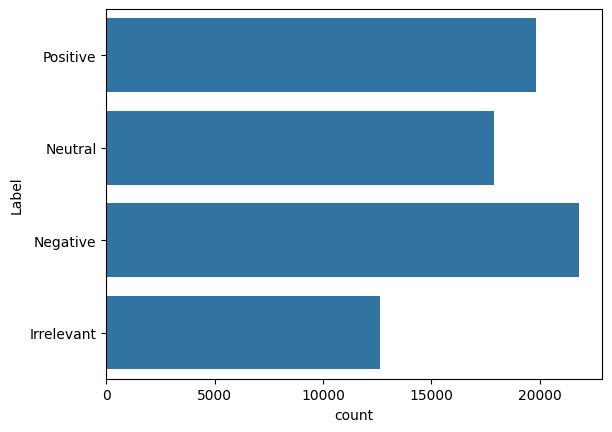

In [20]:
# Countplot Emotion
sb.countplot(data.Label)

## Import NTLK and Other Required Library

In [21]:
# Import Required Library
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.preprocessing import text, sequence
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Stopwords

In [22]:
stwd = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stwd.update(punctuation)

## Cleaning Text

In [23]:
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

stwd = stopwords.words('english')

def clean_text(text):

    cleaned_text = text
    cleaned_text = strip_html(cleaned_text)
    cleaned_text = remove_between_square_brackets(cleaned_text)
    cleaned_text = remove_url(cleaned_text)
    cleaned_text = remove_stopwords(cleaned_text)

    return cleaned_text

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_url(text):
    return re.sub(r'http\S+', '', text)

def remove_stopwords(text):
    final_text = []
    for word in text.split():
        if word.strip().lower() not in stwd:
            final_text.append(word.strip())
    return " ".join(final_text)

data['Text'] = data['Text'].apply(clean_text)

<ipython-input-23-0e0ec3d74f23>:18: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [24]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(data.Text)
corpus[:10]

['coming',
 'borders',
 'kill',
 'all,',
 'im',
 'getting',
 'borderlands',
 'kill',
 'all,',
 'im']

In [25]:
# Total Common Words
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'/': 14594,
 '@': 10984,
 '.': 9957,
 'game': 5661,
 '-': 4623,
 'like': 4271,
 'get': 3503,
 '2': 3055,
 '&': 3038,
 "I'm": 2874}

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    cv = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_words = cv.transform(corpus)
    sum_words = bag_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

## Most Common Words Plot

<Axes: >

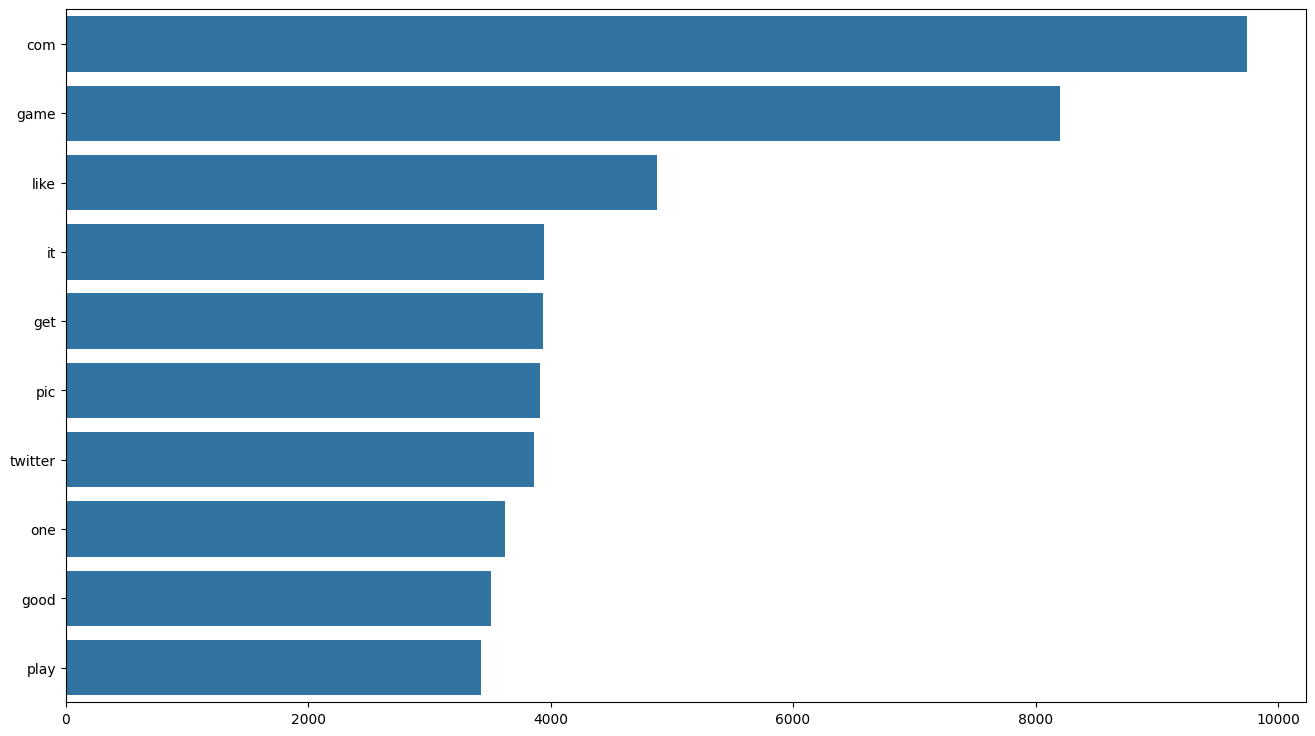

In [27]:
plt.figure(figsize = (16,9))
most_common = get_top_text_ngrams(data.Text, 10, 1)
most_common = dict(most_common)
sb.barplot(x=list(most_common.values()),y=list(most_common.keys()))

## One - Hot Encoding

In [28]:
# Data Label One-Hot Encoding
Label = pd.get_dummies(data.Label, dtype=int)
new_data = pd.concat([data, Label], axis=1)
new_data = new_data.drop(columns='Label')
new_data.head(10)

,Env,Text,Irrelevant,Negative,Neutral,Positive
0,Borderlands,"coming borders kill all,",0,0,0,1
1,Borderlands,"im getting borderlands kill all,",0,0,0,1
2,Borderlands,"im coming borderlands murder all,",0,0,0,1
3,Borderlands,"im getting borderlands 2 murder all,",0,0,0,1
4,Borderlands,"im getting borderlands murder all,",0,0,0,1
5,Borderlands,spent hours making something fun. . . know HUG...,0,0,0,1
6,Borderlands,spent couple hours something fun... know I'm h...,0,0,0,1
7,Borderlands,spent hours something fun... know I'm HUGE @ B...,0,0,0,1
8,Borderlands,spent hours making something fun. . . know HUG...,0,0,0,1
9,Borderlands,2010 spent hours making something fun. . . kno...,0,0,0,1


## Splitting Dataset

In [29]:
import string
from collections import Counter

def process_text(text):
  """
  Preprocesses text data for further analysis.

  Args:
      text (str): The text to be processed.

  Returns:
      list: A list of cleaned and frequent words.
  """

  # Step 1: Remove punctuation (except apostrophes) and convert to lowercase
  text = ''.join(c for c in text.lower() if c in string.ascii_letters + "'")

  # Step 2: Tokenize the text
  words = text.split()

  # Step 3: Remove infrequent words (optional, customize threshold)
  word_counts = Counter(words)
  min_count = 2  # Adjust this threshold as needed
  frequent_words = [word for word, count in word_counts.items() if count >= min_count]

  return frequent_words

data['Text'] = data['Text'].apply(process_text)

In [30]:
datas = new_data['Text'].values
category = new_data[['Irrelevant',	'Negative',	'Neutral',	'Positive']].values

In [31]:
x_train,x_test,y_train,y_test = train_test_split(datas, category, test_size = 0.2, shuffle=True)

## Create Callbacks

In [32]:
# Create Callback
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.9 and logs.get('val_accuracy') > 0.9):
      print(f"Accuracy have been achieved!\nAcc Train: {logs.get('accuracy')}\nAcc Val: {logs.get('val_accuracy')}")
      self.model.stop_training = True
callbacks= Callback()

## Tokenizer

In [33]:
vocab_size = 10000
max_len = 100
trunc_type = "post"
oov_tok = "<oov>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index

sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)
pad_train = pad_sequences(sequences_train, maxlen=max_len, truncating=trunc_type)
pad_test = pad_sequences(sequences_test, maxlen=max_len, truncating=trunc_type)

## Create Model

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy',)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8

## Train Model

In [36]:
history = model.fit(pad_train, y_train, epochs=30, validation_data=(pad_test, y_test), batch_size=64, verbose=2)

Epoch 1/30
902/902 - 42s - loss: 0.9146 - accuracy: 0.6482 - val_loss: 0.7105 - val_accuracy: 0.7314 - 42s/epoch - 47ms/step
Epoch 2/30
902/902 - 12s - loss: 0.5629 - accuracy: 0.8031 - val_loss: 0.5889 - val_accuracy: 0.7872 - 12s/epoch - 13ms/step
Epoch 3/30
902/902 - 9s - loss: 0.4031 - accuracy: 0.8591 - val_loss: 0.5385 - val_accuracy: 0.8070 - 9s/epoch - 10ms/step
Epoch 4/30
902/902 - 10s - loss: 0.3214 - accuracy: 0.8863 - val_loss: 0.5342 - val_accuracy: 0.8236 - 10s/epoch - 11ms/step
Epoch 5/30
902/902 - 10s - loss: 0.2704 - accuracy: 0.9034 - val_loss: 0.5312 - val_accuracy: 0.8338 - 10s/epoch - 11ms/step
Epoch 6/30
902/902 - 8s - loss: 0.2321 - accuracy: 0.9145 - val_loss: 0.6023 - val_accuracy: 0.8343 - 8s/epoch - 9ms/step
Epoch 7/30
902/902 - 9s - loss: 0.2133 - accuracy: 0.9219 - val_loss: 0.5688 - val_accuracy: 0.8411 - 9s/epoch - 10ms/step
Epoch 8/30
902/902 - 8s - loss: 0.1918 - accuracy: 0.9288 - val_loss: 0.6440 - val_accuracy: 0.8402 - 8s/epoch - 8ms/step
Epoch 9/30

## Model Evaluation

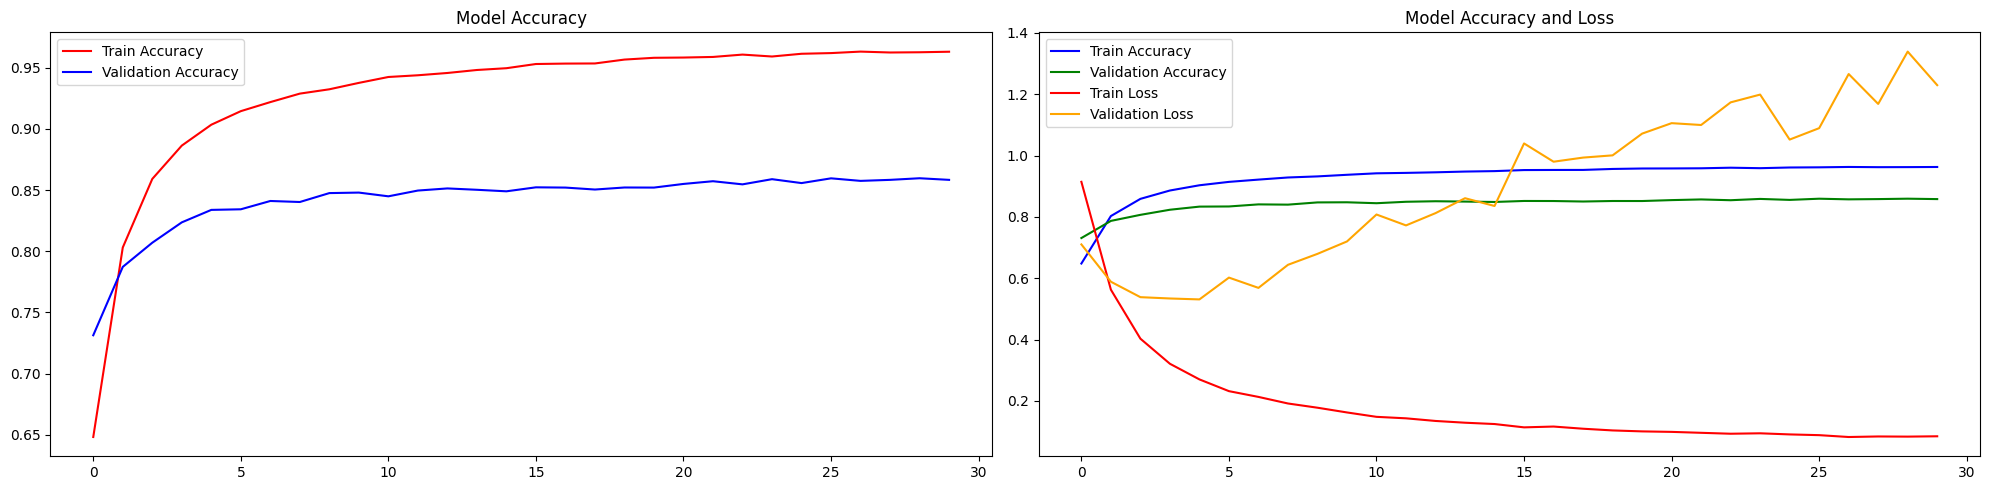

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Create a subplot figure
plt.figure(figsize=(20, 5))  # Adjust figure size as needed

# Subplot for Accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(epochs, acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend(loc=0)

# Subplot for all
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(epochs, acc, 'blue', label='Train Accuracy')
plt.plot(epochs, val_acc, 'green', label='Validation Accuracy')
plt.plot(epochs, loss, 'red', label='Train Loss')
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
plt.title('Model Accuracy and Loss')
plt.legend(loc=0)


# Adjust layout to prevent overlapping elements
plt.tight_layout()

plt.show()